In [ ]:
# hide
# default_exp cli
from nbdev.showdoc import show_doc
from nbdev import *

# CLI

> The command line interface for the HECSS sampler

The hecss sampler can be also used from the command line using `hecss` command:
```bash
~$ hecss --help
usage: hecss [-h] [--workdir WORKDIR] [--label LABEL] [--T T] [--width WIDTH]
             [--calc CALC] [--dfset] [--N N] [--cmd CMD] [--V]
             fname

Run HECSS sampler on the structure passed in fname.

positional arguments:
  fname              Supercell structure file.The containing directory 
                     must be readable by Vasp(restart).

optional arguments:
  -h, --help         show this help message and exit
  --workdir WORKDIR  Output directory for samples (default: calc)
  --label LABEL      Job label passed to run-calc command (default: hecss)
  --T T              Target temperature (K) (default: 300)
  --width WIDTH      Initial scale of the prior distribution (default: 1.0)
  --calc CALC        Type of the calculator. Only VASP supported. (default: VASP)
  --dfset            Write DFset file (default: True)
  --N N              Number of samples (default: 10)
  --cmd CMD          Command for job submission (default: ./run-calc)
  --V                Print version and exit (default: False)

```

To use it you need to prepare:

1. `run-calc` script which should start the VASP calculation. You need to put this script in the root of your project tree. The example of such a script is included in the source as `run-calc.example`. :

```bash
#!/bin/bash

# This script should run vasp in current directory 
# and wait for the run to finish.
# 
# A generic line using SLURM would look like this:
#
# sbatch [job_params] -W vasp_running_script
#
# The "-W" param makes the sbatch command wait for the job to finish.


JN=`pwd`
JN=`basename ${JN}`

# Partition of the cluster
PART=small

# Number of nodes
N=1

# Number of MPI tasks
ntask=64

# Name the job after directory if no label is passed as first argument
if [ "${1}." != "." ]; then
  JN=${1}
fi

sbatch -W -J ${JN} -p $PART -N $N -n $ntask run-vasp-script
```

2. A directory with fully converged and optimized supercell structure which can be read in by the ASE `Vasp(restart=...)` command

3. A directory for the generated samples.

The directory tree may look like this:

```
my_project ----- sc
             |
             +-- T_100
             |
             +-- T_200
             |
             +-- ...
             |
             +-- run-calc
```

You execute the sampler from the `my_project` directory (remember to activate your virtual environment first). Generation of N=30 samples at T=100K:

```bash
~$ cd my_project
~$ hecss --workdir T_100 --T 100 --N 30 --cmd ./run-calc sc
```

The above command will put the generated samples inside the `T_100` directory, together with the DFSET file with displacement-force data extracted from the calculation. The calculation may take a long time. Thus it is advisable to execute the hecss command inside `screen` (or some similar terminal multiplexer) to prevent the break of the calculation in case of session disconnection. The `hecss` command shows a progress to guide you through the calculation (ETA, time/it, data about last sample etc.). The example run is included at the bottom of this document.

In [ ]:
# hide
# export
import click
from fastcore.script import Param, call_parse, bool_arg, store_true, store_false
from pathlib import Path
import os
import ase
from ase.calculators.vasp import Vasp
from ase import units as un
from hecss.core import *

In [ ]:
from hecss.monitor import plot_stats

In [ ]:
# export
def dfset_writer(s, sl, workdir=''):
    '''
    Just write samples to the DFSET.dat file in the workdir directory.
    '''
    wd = Path(workdir)
    write_dfset(f'{wd.joinpath("DFSET.dat")}', s)
    # Important! Return False to keep iteration going
    return False

In [ ]:
# export
@call_parse
def hecss_sampler(fname:  Param("Supercell structure file."
                                "The containing directory must be readable by Vasp(restart)."
                                , str),
                  workdir:Param("Output directory for samples", str)='calc', 
                  label:  Param("Job label passed to run-calc command", str)='hecss',
                  T:      Param("Target temperature (K)", float)=300,
                  width:  Param("Initial scale of the prior distribution", float)=1.0,
                  calc:   Param("Type of the calculator. Only VASP supported.", str)='VASP',
                  dfset:  Param("Write DFset file", store_false)=True, 
                  N:      Param("Number of samples", int)=10, 
                  cmd:    Param("Command for job submission", str)='./run-calc',
                  V:      Param("Print version and exit", store_true)=False):
    '''
    Run HECSS sampler on the structure passed in fname.
    '''
    
    import hecss

    if V:
        print(f'HECSS ver. {hecss.__version__}\n'
               'High Efficiency Configuration Space Sampler\n'
               '(C) 2021 by Paweł T. Jochym\n'
               '    License: GPL v3 or later')
        return

    
    print(f'HECSS ({hecss.__version__})\n'
          f'Supercell:      {fname}\n'
          f'Temperature:    {T}K\n'
          f'Work directory: {workdir}\n'
          f'Calculator:     {calc}.')
    
    src_path = Path(fname)
    
    if calc=="VASP":
        calculator = Vasp(label=label, directory=src_path.parent, restart=True)
        cryst = ase.Atoms(calculator.atoms)
        cryst.set_calculator(calculator)
        calculator.set(directory=workdir)
        command = Path(cmd)
        calculator.set(command=f'{command.absolute()} {label}')
    else:
        print(f'The {calc} calculator is not supported.')
        return
    sentinel = None
    if dfset :
        sentinel = dfset_writer
    sampler = HECSS(cryst, calculator, T, directory=workdir, width=width)
    samples = sampler.generate(N, sentinel=sentinel, workdir=workdir)
    return samples

In [ ]:
hecss_sampler('POSCAR',V=True)

HECSS ver. 0.3.13
High Efficiency Configuration Space Sampler
(C) 2021 by Paweł T. Jochym
    License: GPL v3 or later


In [ ]:
# export
@click.command()
@click.argument('fname', type=click.Path(exists=True))            
@click.option('-W', '--workdir', default="WORK", type=click.Path(exists=True), help="Work directory")
@click.option('-l', '--label', default="hecss", help="Label for the calculations.")
@click.option('-T', '--temp', default=300, type=float, help="Target temperature in Kelvin.")
@click.option('-w', '--width', default=1.0, type=float, help="Initial scale of the prior distribution")
@click.option('-C', '--calc', default="VASP", type=str, 
              help="ASE calculator to be used for the job.\n" + "Supported calculators: VASP (default)")
@click.option('--dfset/--no-dfest', default=True, help='Write DFSET file for ALAMODE')
@click.option('-N', '--nsamples', default=10, type=int, help="Number of samples to be generated")
@click.option('-c', '--command', default='./run-calc', help="Command to run calculator")
def _hecss_sampler(fname, workdir, label, temp, width, calc, dfset, nsamples, command):
    '''
    Run HECSS sampler on the structure in the directory.
    fname - Supercell structure file. 
    The containing directory must be readable by Vasp(restart).
    '''
    return hecss_sampler(fname=fname, 
                         workdir=workdir, 
                         label=label, 
                         T=temp, 
                         width=width,
                         calc=calc, 
                         dfset=dfset, 
                         N=nsamples, 
                         cmd=command)

In [ ]:
# vasp
# slow
samples = hecss_sampler(fname="example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR", 
                        workdir='TMP', T=300, width=1.1, N=300)

HECSS (0.3.13)
Supercell:      example/VASP_3C-SiC/1x1x1/sc_1x1x1/CONTCAR
Temperature:    300K
Work directory: TMP
Calculator:     VASP.


0it [00:00, ?it/s]

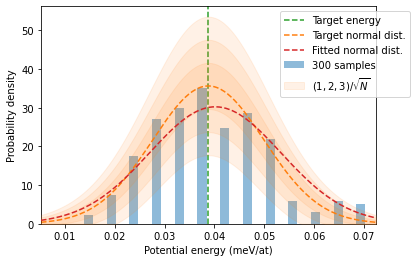

In [ ]:
# vasp
# slow
plot_stats(samples, 300)